In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.initializers import *
from keras.models import load_model
from keras.losses import *
import theano.tensor as T
import theano
from sklearn import metrics
from sklearn.preprocessing import *
from scipy.fftpack import dct, idct
from keras.activations import softmax
from sklearn.cluster import KMeans, MiniBatchKMeans
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 Ti (CNMeM is disabled, cuDNN 5105)


In [2]:
# external custom code I wrote
from load_data import *
from windowing import *
from utility import *
from pesq import *
from consts import *
from nn_blocks import *
from transforms import *

In [3]:
# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# number of speech files for train, val, and test
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 500

# during training, we evaluate PESQ and RMSE and such on full speech files every epoch, which
# is kind of expensive. so instead of selecting the full training and validation set, we
# randomly select this many waveforms
TRAIN_EVALUATE = 50
VAL_EVALUATE = 50

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101814, 512, 1)
6.41179e-06
0.103588
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
# softmax hardness variable
tau = K.variable(0.0001, name = "hardness")
tau_add_rate = 0.1

NBINS = 32
VEC_SIZE = 1

# initially, quantization is not on
QUANT_BINS = K.zeros((NBINS, VEC_SIZE), name = 'QUANT_BINS')
QUANTIZATION_ON = K.variable(False)

DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR

In [8]:
def unquantize_batch(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [2, 0])
    out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
    return out

def unquantize_vec(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [1, 0])
    out = K.reshape(out, (CHANNEL_SIZE,))
    return out

class SoftmaxQuantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxQuantization, self).__init__(**kwargs)
   
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(256.0)
        self.trainable_weights = [QUANT_BINS,
                                  self.SOFTMAX_TEMP]
        super(SoftmaxQuantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        # x is an array: [BATCH x WINDOW_SIZE]
        # x_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x 1 x VEC_SIZE]
        x_r = K.reshape(x, (-1, x.shape[1] // VEC_SIZE, 1, VEC_SIZE))

        # quant_bins is an array: [NBINS x VEC_SIZE] 
        # q_r becomes: [1 x 1 x NBINS x VEC_SIZE]
        q_r = K.reshape(QUANT_BINS, (1, 1, QUANT_BINS.shape[0], VEC_SIZE))

        # get L2 distance from each element to each of the bins
        dist = K.sqrt(K.sum(K.square(x_r - q_r), axis = -1) + K.epsilon())

        # turn into softmax probabilities, which we return
        probs = softmax(self.SOFTMAX_TEMP * -dist)
        
        # if quantization isn't on yet, we just return the original vector x, reshaped
        # and padded to the right shape
        #     (this is a bad hack and I hope there is a better way to do this)
        quant_on = probs
        quant_off = K.zeros_like(quant_on)
        quant_off = T.set_subtensor(quant_off[:, :, :VEC_SIZE],
                                    K.reshape(x, (-1, x.shape[1] // VEC_SIZE, VEC_SIZE)))
        
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] // VEC_SIZE, NBINS)


class SoftmaxDequantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxDequantization, self).__init__(**kwargs)
        self.supports_masking = False
    
    def build(self, input_shape):
        self.trainable_weights = []
        super(SoftmaxDequantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        out = T.tensordot(x, QUANT_BINS, axes = [2, 0])
        out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
        
        quant_on = out
        quant_off = K.reshape(x[:, :, :VEC_SIZE], (-1, x.shape[1] * VEC_SIZE))
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * VEC_SIZE)

In [9]:
NUM_MFCC_COEFFS = 64

# precompute Mel filterbank
MEL_FILTERBANK_NPY = melFilterBank(NUM_MFCC_COEFFS).transpose()
MEL_FILTERBANK = K.variable(MEL_FILTERBANK_NPY)

# we precompute matrices for MFCC calculation
DFT_REAL, DFT_IMAG = generate_dft_mats(WINDOW_SIZE)
MFCC_DCT = generate_dct_mat(NUM_MFCC_COEFFS)

# given a (symbolic Theano) array of size M x WINDOW_SIZE (or M x WINDOW_SIZE x 1)
#     this returns an array M x N where each window has been replaced
#     by some perceptual transform (in this case, MFCC coeffs)
def perceptual_transform(x):
    powerSpectrum = T.pow(theano_dft_mag(x, DFT_REAL, DFT_IMAG), 2)
    filteredSpectrum = T.tensordot(powerSpectrum, MEL_FILTERBANK, axes = 1)
    logSpectrum = T.log(filteredSpectrum + K.epsilon())
    
    mfccs = theano_dct(logSpectrum, MFCC_DCT)[:, 1:-1]
    return mfccs

# perceptual loss function
def perceptual_distance(y_true, y_pred):
    y_true = K.reshape(y_true, (y_true.shape[0], y_true.shape[1]))
    y_pred = K.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
    #silent_frame = K.max(K.abs(y_true), axis = -1) >= 0.01
    
    pvec_true = perceptual_transform(y_true)
    pvec_pred = perceptual_transform(y_pred)
    
    distance = rmse(pvec_true, pvec_pred)
    return distance
    #return distance * silent_frame

In [10]:
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 9
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    #enc = channel_increase_block(NCHAN, FILT_SIZE)(enc)
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    
    #enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    
    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = channel_change_block(1, FILT_SIZE)(enc)
    #enc = channel_decrease_block(NCHAN, FILT_SIZE)(enc)
    
    enc = Reshape((CHANNEL_SIZE,))(enc)
    #enc = Dense(CHANNEL_SIZE)(enc)
    
    # softmax quantization
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE / VEC_SIZE, NBINS))
    dec = dec_input
    
    dec = SoftmaxDequantization()(dec)
    
    # increase number of channels via convolution
    #dec = Dense(CHANNEL_SIZE)(dec)
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    #dec = channel_increase_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    #dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    
    # decrease back down to 1 channel
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(1, FILT_SIZE)(dec)
    #dec = channel_decrease_block(NCHAN, FILT_SIZE)(dec)
    
    #dec = Activation('tanh')(dec)
    #dec = Lambda(lambda x : K.clip(x, -1.0, 1.0))(dec)
    
    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [11]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (code.shape[0] * code.shape[1], NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return K.switch(QUANTIZATION_ON, tau * entropy, 0.0)

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return K.switch(QUANTIZATION_ON, sparsity, 0.0)

In [12]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'EuclideanDistance': EuclideanDistance,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'NBINS' : NBINS,
                  'QUANT_BINS' : QUANT_BINS,
                  'VEC_SIZE' : VEC_SIZE,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'DFT_REAL' : DFT_REAL,
                  'DFT_IMAG' : DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'theano_dft_mag' : theano_dft_mag,
                  'theano_dct' : theano_dct,
                  'perceptual_transform' : perceptual_transform,
                  'perceptual_distance' : perceptual_distance}

In [13]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

In [14]:
# model parameters
loss_weights = [300.0, 10.0, 10.0, 1.0]
loss_functions = [rmse, perceptual_distance, code_sparsity, code_entropy]
n_recons = 2
n_code = 2
assert(n_recons + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [15]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_reconstructed = decoder(model_embedding)

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code)

In [16]:
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam(lr = 0.001))

#autoencoder.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 256, 32)           92526     
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            103853    
Total params: 196,379.0
Trainable params: 196,379.0
Non-trainable params: 0.0
_________________________________________________________________


In [17]:
# test model on a set of speech windows (which should originally have been extracted in
# order from some speech waveform)
def test_model_on_windows(orig_windows, wparams, autoencoder, argmax = False):
    # first, get desired reconstruction
    desired = reconstruct_from_windows(orig_windows, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocess_waveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    
    # then, run NN on windows to get our model's reconstruction
    transformed = np.reshape(orig_windows, (orig_windows.shape[0], WINDOW_SIZE, 1))
    enc = autoencoder.layers[1]
    embed = enc.predict(transformed, batch_size = 128, verbose = 0)
    if (argmax):
        for wnd in xrange(0, embed.shape[0]):
            max_idxs = np.argmax(embed[wnd], axis = -1)
            embed[wnd] = np.eye(NBINS)[max_idxs]
    
    dec = autoencoder.layers[2]
    autoencOutput = dec.predict(embed, batch_size = 128, verbose = 0)
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    recons = reconstruct_from_windows(autoencOutput, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocess_waveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    # compute PESQ between desired and reconstructed waveforms
    pesq = run_pesq_waveforms(desired, recons)
    
    # return some metrics, as well as the two waveforms
    metrics = [
        mse(recons, desired),
        avgErr(recons, desired),
        pesq
    ]
    
    return metrics, desired, recons

In [18]:
# test model given the filename for a .wav file
def test_model_on_wav(wave_filename, prefix, autoencoder,
                      lead = "", save_recons = True, verbose = True,
                      argmax = False):
    [rate, data] = sciwav.read(wave_filename)
    data = data.astype(np.float32)
    processed_wave, wparams = preprocess_waveform(data)
    windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)
    
    metrics, desired, recons = test_model_on_windows(windows, wparams, autoencoder, argmax)
    
    if (save_recons):
        outFilename = prefix + "_output.wav"
        sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))
    
    if (verbose):
        print lead + "MSE:        ", metrics[0]
        print lead + "Avg err:    ", metrics[1]
        print lead + "PESQ:       ", metrics[2]
        
    return metrics

In [19]:
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('best_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [20]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         40036.0
Avg err:     107.254
PESQ:        1.279


[40035.953, 107.25391, 1.279]

In [21]:
def evaluate_training(autoencoder, lead = ""):
    train_eval_idxs = random.sample(range(0, len(train_windows) - 1), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows) - 1), VAL_EVALUATE)
    
    train_metrics = []
    for idx in train_eval_idxs:
        windows = train_windows[idx]
        wparams = train_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        train_metrics.append(metrics)
        
    val_metrics = []
    for idx in val_eval_idxs:
        windows = val_windows[idx]
        wparams = val_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        val_metrics.append(metrics)
    
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [22]:
def avg_weight_change(before, after):
    avg = 0.0
    
    for i in xrange(0, len(before)):
        diff = np.mean(np.abs(before[i] * 1000.0 - after[i] * 1000.0))
        avg += diff
        
    avg /= float(len(before))
    return avg

In [23]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]
    
    return r

In [24]:
X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_EPOCHS = 200
EPOCHS_BEFORE_QUANT = 5
EPOCHS_BEFORE_TAU = EPOCHS_BEFORE_QUANT + 5
NUM_QUANT_VECS = 5000

ORIG_BITRATE = 256.00
TARGET_BITRATE = 16.00
PRE_ENTROPY_RATE = ORIG_BITRATE / DOWNSAMPLE_FACTOR / VEC_SIZE

TARGET_ENTROPY = (TARGET_BITRATE / PRE_ENTROPY_RATE * 16.0)
TARGET_ENTROPY *= (STEP_SIZE / float(WINDOW_SIZE))
TARGET_ENTROPY_FUZZ = 0.1

print "Target entropy:", TARGET_ENTROPY

Target entropy: 1.875


In [25]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

lead = "    "
best_val_pesq = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
               
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code       

        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau),
        
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy
        
        if (epoch >= EPOCHS_BEFORE_TAU):
            old_tau = K.get_value(tau)
            
            if (entropy < TARGET_ENTROPY - TARGET_ENTROPY_FUZZ):
                new_tau = old_tau - tau_add_rate
                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            elif (entropy > TARGET_ENTROPY + TARGET_ENTROPY_FUZZ):
                new_tau = old_tau + tau_add_rate
                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            else:
                print lead + "Tau stays at", old_tau
        
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq and entropy <= TARGET_ENTROPY):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq

            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq

            #curr_lr = model.optimizer.lr.get_value()
            #K.set_value(model.optimizer.lr, curr_lr * 0.98)
            #print lead + "Decreased learning rate from", curr_lr, "to", curr_lr * 0.98
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
    else:
        print lead + "    (Not saving model yet)"
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
        
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) == 0):
        if (epoch >= EPOCHS_BEFORE_QUANT):
            print lead + "----------------"
            print lead + "Turning quantization on!"
            
            random_windows = []
            for i in xrange(0, NUM_QUANT_VECS):
                w_idx = random.randint(0, train_processed.shape[0] - 1)
                random_windows.append(train_processed[w_idx])
            
            random_windows = np.array(random_windows)
            print lead + "    Selecting random code vectors for clustering..."
            encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
            encoded_windows = encoded_windows[:, :, :VEC_SIZE]            
            encoded_windows = np.reshape(encoded_windows, (-1, VEC_SIZE))
            
            print lead + "    K means clustering for bins initialization..."
            km = MiniBatchKMeans(n_clusters = NBINS).fit(encoded_windows)
            K.set_value(QUANT_BINS, km.cluster_centers_)
            K.set_value(QUANTIZATION_ON, True)
            
            cluster_score = np.sqrt(np.median(np.min(km.transform(encoded_windows), axis = 1)))
            print lead + "    Done. Cluster score:", cluster_score
            
            curr_lr = model.optimizer.lr.get_value()
            K.set_value(model.optimizer.lr, curr_lr / 2.0)
            print lead + "Decreased learning rate from", curr_lr, "to", curr_lr / 2.0

Epoch 1:
    101120:  [6.778085 0.004244 0.550494 0.000000 0.000000] [6.778085 1.273147 5.504938 0.000000 0.000000] 9.99999974738e-05 
    Total time for epoch: 198.616806984s
    ----------------
    Evaluating autoencoder...
    SA1:          [1746.8325, 20.669437, 4.074]
    SX383:        [2795.1018, 16.815321, 3.948]
        (Not saving model yet)
    Total time for evaluation: 0.556437969208s
Epoch 2:
    101120:  [6.740635 0.006702 0.473004 0.000000 0.000000] [6.740635 2.010597 4.730038 0.000000 0.000000] 9.99999974738e-05 
    Total time for epoch: 161.67060709s
    ----------------
    Evaluating autoencoder...
    SA1:          [1738.5314, 20.956213, 4.242]
    SX383:        [2882.1267, 17.486, 3.96]
        (Not saving model yet)
    Total time for evaluation: 0.553833007812s
Epoch 3:
    101120:  [7.284322 0.007098 0.515505 0.000000 0.000000] [7.284322 2.129269 5.155052 0.000000 0.000000] 9.99999974738e-05 
    Total time for epoch: 161.111915827s
    ----------------
    Ev

In [26]:
nqv = 5000
vs = 1
nb = 16

random_windows = []
for i in xrange(0, nqv):
    w_idx = random.randint(0, train_processed.shape[0] - 1)
    random_windows.append(train_processed[w_idx])

random_windows = np.array(random_windows)
print lead + "    Selecting random code vectors for clustering..."
encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
encoded_windows = encoded_windows[:, :, :vs]            
encoded_windows = np.reshape(encoded_windows, (-1, vs))

# subtract mean from bins before clustering
bins_mean = np.mean(encoded_windows, axis = 0)
mean_subtracted = encoded_windows - bins_mean

print lead + "    K means clustering for bins initialization..."
km = MiniBatchKMeans(n_clusters = nb).fit(mean_subtracted)

cluster_score = np.sqrt(np.mean(np.min(km.transform(mean_subtracted), axis = 1)))
print lead + "    Done. Cluster score:", cluster_score

        Selecting random code vectors for clustering...
        K means clustering for bins initialization...
        Done. Cluster score: 0.0388937


In [27]:
if True:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]
    QUANT_BINS = K.variable(np.load('best_quant_bins.npy'))

/usr/local/lib/python2.7/dist-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [28]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [29]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         3007.39
Avg err:     36.1959
PESQ:        3.208
MSE:         3115.16
Avg err:     36.9085
PESQ:        3.152
MSE:         1638.17
Avg err:     24.9546
PESQ:        3.213
MSE:         1687.59
Avg err:     25.3467
PESQ:        3.177
MSE:         1.50475e+06
Avg err:     834.573
PESQ:        3.044
MSE:         1.51288e+06
Avg err:     838.697
PESQ:        3.031


In [30]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9856/10000 [============================>.] - ETA: 0s

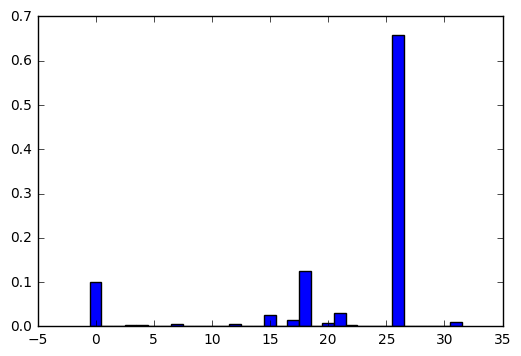

Entropy of distribution: 1.85149312103
Bins:
CudaNdarray([[0.292937]
 [2.676219]
 [-2.577726]
 [1.454840]
 [1.327387]
 [-1.548935]
 [1.722313]
 [-1.009677]
 [2.143440]
 [-2.130440]
 [3.228236]
 [-3.217024]
 [1.187864]
 [2.913730]
 [1.994187]
 [-0.714015]
 [-2.413305]
 [0.706548]
 [-0.385035]
 [-1.981590]
 [1.037246]
 [0.519770]
 [1.588157]
 [2.470838]
 [-1.293278]
 [2.294805]
 [-0.017610]
 [1.854640]
 [-2.259988]
 [-2.810944]
 [-1.781455]
 [0.876079]])


In [31]:
if (K.get_value(QUANTIZATION_ON) > 0):
    probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
    hist = np.sum(probs, axis = 0)
    hist /= np.sum(hist)

    sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
    plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
    plt.show()

    entropy = 0
    for i in hist:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print "Entropy of distribution:", entropy

    print "Bins:"
    print QUANT_BINS.eval()

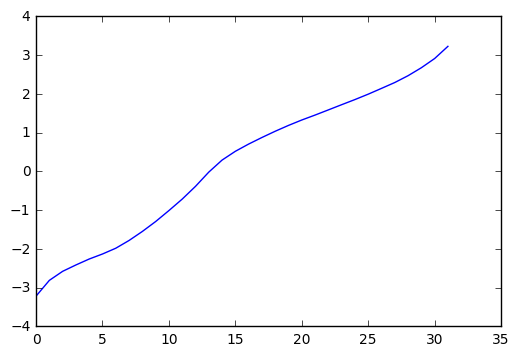

In [32]:
plt.plot(np.sort(np.array(QUANT_BINS.eval()).flatten()))
plt.show()

In [33]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [34]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [35]:
enc[-1].SOFTMAX_TEMP.eval()

CudaNdarray(323.475158691)

In [36]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 0.999846 1.000000 1.000000 1.000000 1.000000 0.999984 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.999999
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 0.999993 1.000000 1.000000 1.000000 0.976721
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 0.999998 1.000000 1.000000 1.000000
 1.000000 1.000000 0.999999 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000

In [37]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.995578
0.976388113839


Original


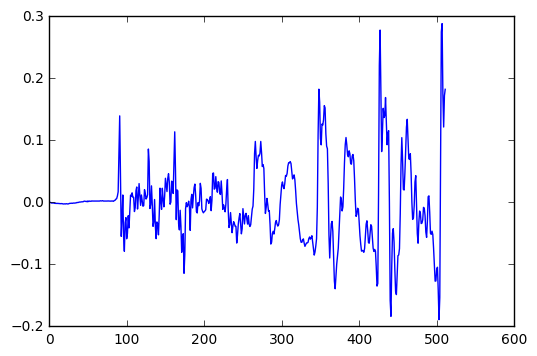

Reconstruction


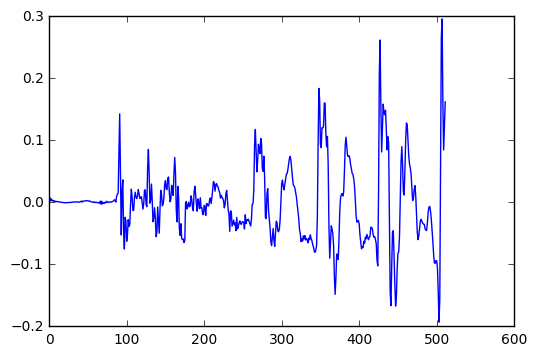

Code (argmax)


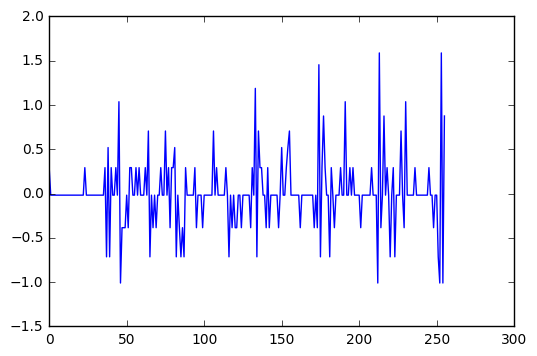

Code (non-argmax)


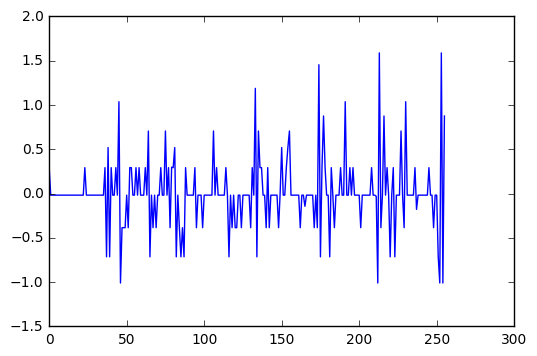

Difference


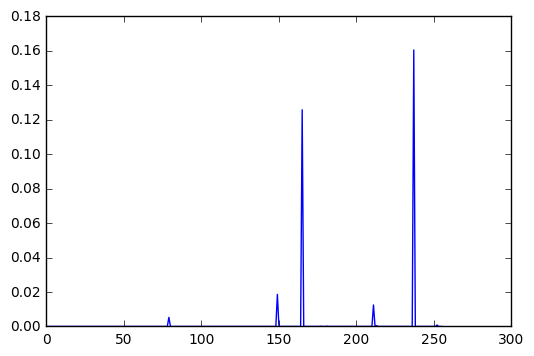

Error


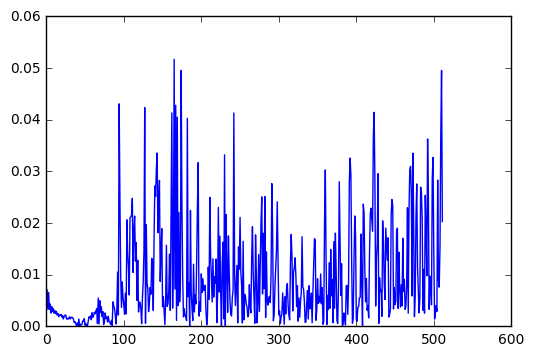

In [38]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Code (argmax)"
    argmax_code_vec = embed[idx]
    embed_sum = np.sum(embed[idx], axis = -1)
    argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
    argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
    argmax_code_vec = unquantize_vec(argmax_code_vec).eval()
    plt.plot(argmax_code_vec)
    plt.show()
    
    print "Code (non-argmax)"
    na_code_vec = embed[idx]
    na_code_vec = unquantize_vec(na_code_vec).eval()
    plt.plot(na_code_vec)
    plt.show()
    
    print "Difference"
    plt.plot(abs(argmax_code_vec - na_code_vec))
    plt.show()
else:
    print "Code (pre-quantization)"
    code_vec = embed[idx][:, :VEC_SIZE].flatten()
    plt.plot(code_vec)
    plt.show()
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()